In [1]:
%env ARTS_INCLUDE_PATH=/home/simonpf/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simonpf/build/arts_new/

from typhon.arts.workspace import Workspace

env: ARTS_INCLUDE_PATH=/home/simonpf/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simonpf/build/arts_new/
Loading ARTS API from: /home/simonpf/build/arts_new/src/libarts_api.so


In [2]:
ws = Workspace()
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

ARTS[61420672]: 320
ARTS[61420672]: Executing /home/simonpf/src/arts_clean/controlfiles/general/general.arts
ARTS[61420672]: {
ARTS[61420672]: 320
ARTS[61420672]: - verbosityInit
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 357
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 358
ARTS[61420672]: 320
ARTS[61420672]: - scat_speciesSet
ARTS[61420672]: 256
ARTS[61420672]: 320
ARTS[61420672]: 358
ARTS[61420672]: 357
ARTS[61420672]: 256
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 357
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 358
ARTS[61420672]: 320
ARTS[61420672]: - MatrixSet
ARTS[61420672]: 320
ARTS[61420672]: 188
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 360
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 361
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 362
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 363
ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 364
ARTS[61420672]: 320

In [3]:
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 429
ARTS[61420672]: 28

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 380
ARTS[61420672]: 117

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 393
ARTS[61420672]: 118

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 396
ARTS[61420672]: 120

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 414
ARTS[61420672]: 213

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 407
ARTS[61420672]: 206

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 412
ARTS[61420672]: 211



In [4]:
ws.stokes_dim = 2
ws.cloudboxOff()
ws.jacobianOff()

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 457
ARTS[61420672]: 288

ARTS[61420672]: 320
ARTS[61420672]: 50
ARTS[61420672]: 49
ARTS[61420672]: 115
ARTS[61420672]: 202
ARTS[61420672]: 67
ARTS[61420672]: 246
ARTS[61420672]: 248
ARTS[61420672]: 188
ARTS[61420672]: 320
ARTS[61420672]: 130
ARTS[61420672]: 188
ARTS[61420672]: 248
ARTS[61420672]: 246
ARTS[61420672]: 67
ARTS[61420672]: 202
ARTS[61420672]: 115
ARTS[61420672]: 49
ARTS[61420672]: 50

ARTS[61420672]: 320
ARTS[61420672]: 127
ARTS[61420672]: 128
ARTS[61420672]: 126
ARTS[61420672]: 130
ARTS[61420672]: 129
ARTS[61420672]: 320
ARTS[61420672]: 129
ARTS[61420672]: 130
ARTS[61420672]: 126
ARTS[61420672]: 128
ARTS[61420672]: 127



In [5]:
ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
ws.abs_speciesSet( species=["N2", "O2", "H2O"] )
# Read a line file and a matching small frequency grid
ws.abs_linesReadFromSplitArtscat(
    ws.abs_species,
    "spectroscopy/Perrin/",
    10e9,
    250e9
    )
# Sort the line file according to species
ws.abs_lines_per_speciesCreateFromLines()

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 459
ARTS[61420672]: 458
ARTS[61420672]: 457
ARTS[61420672]: 218

ARTS[61420672]: 320
ARTS[61420672]: 20
ARTS[61420672]: 29
ARTS[61420672]: 214
ARTS[61420672]: 320
ARTS[61420672]: 457
ARTS[61420672]: 214
ARTS[61420672]: 29
ARTS[61420672]: 20

ARTS[61420672]: 320
ARTS[61420672]: 7
ARTS[61420672]: 320
ARTS[61420672]: 459
ARTS[61420672]: 458
ARTS[61420672]: 457
ARTS[61420672]: 20
ARTS[61420672]: 7

ARTS[61420672]: 320
ARTS[61420672]: 9
ARTS[61420672]: 320
ARTS[61420672]: 20
ARTS[61420672]: 7
ARTS[61420672]: 9



In [6]:
from typhon.arts.workspace.variables import *

ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
# Atmospheric scenario
ws.AtmRawRead( basename="planets/Earth/Fascod/midlatitude-summer/midlatitude-summer" )

# Create a frequency grid
ws.VectorNLinSpace( f_grid, 1000, 10e+9, 250e+9 )
# No sensor properties
ws.sensorOff()
# We select here to use Planck brightness temperatures
ws.StringSet( iy_unit, "PlanckBT" )
# Extract optical depth as auxiliary variables
ws.ArrayOfStringSet( iy_aux_vars, [ "Optical depth"] )
# Create vector container for the optical depth
odepth = ws.VectorCreate()


ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 459
ARTS[61420672]: 458
ARTS[61420672]: 457
ARTS[61420672]: 218

ARTS[61420672]: 320
ARTS[61420672]: 316
ARTS[61420672]: 352
ARTS[61420672]: 322
ARTS[61420672]: 317
ARTS[61420672]: 170
ARTS[61420672]: 320
ARTS[61420672]: 457
ARTS[61420672]: 20
ARTS[61420672]: 170
ARTS[61420672]: 317
ARTS[61420672]: 322
ARTS[61420672]: 352
ARTS[61420672]: 316

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 459
ARTS[61420672]: 458
ARTS[61420672]: 457
ARTS[61420672]: 99

ARTS[61420672]: 320
ARTS[61420672]: 272
ARTS[61420672]: 277
ARTS[61420672]: 279
ARTS[61420672]: 275
ARTS[61420672]: 278
ARTS[61420672]: 280
ARTS[61420672]: 276
ARTS[61420672]: 147
ARTS[61420672]: 320
ARTS[61420672]: 99
ARTS[61420672]: 288
ARTS[61420672]: 147
ARTS[61420672]: 276
ARTS[61420672]: 280
ARTS[61420672]: 278
ARTS[61420672]: 275
ARTS[61420672]: 279
ARTS[61420672]: 277
ARTS[61420672]: 272

ARTS[61420672]: 320

ARTS[61420672]: 320



In [7]:
import numpy as np
# Atmosphere and surface
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()
ws.Extract( ws.z_surface, ws.z_field, 0 )
ws.Extract( ws.t_surface, ws.t_field, 0 )

# Definition of sensor position and line of sight (LOS)
ws.MatrixSet( ws.sensor_pos, np.array([[180.0]])) # 10e3 for sensor in z = 10 km
ws.MatrixSet( ws.sensor_los, np.array([[180.0]])) # zenith angle: 0 looking up, 180 looking nadir

# Perform RT calculations
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()

ARTS[61420672]: 320
ARTS[61420672]: 35
ARTS[61420672]: 132
ARTS[61420672]: 138
ARTS[61420672]: 320
ARTS[61420672]: 138
ARTS[61420672]: 132
ARTS[61420672]: 35

ARTS[61420672]: 320
ARTS[61420672]: 314
ARTS[61420672]: 351
ARTS[61420672]: 321
ARTS[61420672]: 315
ARTS[61420672]: 320
ARTS[61420672]: 461
ARTS[61420672]: 460
ARTS[61420672]: 459
ARTS[61420672]: 458
ARTS[61420672]: 35
ARTS[61420672]: 317
ARTS[61420672]: 322
ARTS[61420672]: 352
ARTS[61420672]: 316
ARTS[61420672]: 138
ARTS[61420672]: 132
ARTS[61420672]: 218
ARTS[61420672]: 315
ARTS[61420672]: 321
ARTS[61420672]: 351
ARTS[61420672]: 314

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 458
ARTS[61420672]: 351
ARTS[61420672]: 354

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 458
ARTS[61420672]: 314
ARTS[61420672]: 318

ARTS[61420672]: 320

ARTS[61420672]: 320

ARTS[61420672]: 320
ARTS[61420672]: 29
ARTS[61420672]: 320
ARTS[61420672]: 28
ARTS[61420672]: 20
ARTS[61420672]: 29

ARTS[61420672]: 320
ARTS[61420672]: 214


## Surface Agendas

In [8]:
import numpy as np
from typhon.arts.workspace import arts_agenda

ws.NumericCreate("wind_speed")
ws.NumericCreate("wind_direction")
ws.VectorCreate("transmittance")
ws.wind_speed     = 0.0
ws.wind_direction = 0.0
ws.transmittance  = np.ones(ws.f_grid.value.shape)

@arts_agenda
def surface_fastem(ws):
    ws.Print("bla", 1)
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceFastem(wind_speed     = ws.wind_speed,
                     wind_direction = ws.wind_direction,
                     transmittance  = ws.transmittance)
    
@arts_agenda
def surface_tessem(ws):
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceTessem(wind_speed     = ws.wind_speed)

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 461
ARTS[61420672]: 458

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 461
ARTS[61420672]: 459

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 461
ARTS[61420672]: 460



### Fastem Calculations

In [9]:
ws.Copy(ws.surface_rtprop_agenda, surface_fastem)
ws.yCalc()
y_fastem = np.copy(ws.y)

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 468
ARTS[61420672]: 298

ARTS[61420672]: 320
ARTS[61420672]: 334
ARTS[61420672]: 337
ARTS[61420672]: 340
ARTS[61420672]: 341
ARTS[61420672]: 339
ARTS[61420672]: 335
ARTS[61420672]: 338
ARTS[61420672]: 125
ARTS[61420672]: 320
ARTS[61420672]: 114
ARTS[61420672]: 129
ARTS[61420672]: 130
ARTS[61420672]: 127
ARTS[61420672]: 126
ARTS[61420672]: 104
ARTS[61420672]: 117
ARTS[61420672]: 124
ARTS[61420672]: 275
ARTS[61420672]: 279
ARTS[61420672]: 277
ARTS[61420672]: 272
ARTS[61420672]: 147
ARTS[61420672]: 313
ARTS[61420672]: 268
ARTS[61420672]: 271
ARTS[61420672]: 99
ARTS[61420672]: 288
ARTS[61420672]: 266
ARTS[61420672]: 47
ARTS[61420672]: 50
ARTS[61420672]: 321
ARTS[61420672]: 351
ARTS[61420672]: 314
ARTS[61420672]: 35
ARTS[61420672]: 36
ARTS[61420672]: 37
ARTS[61420672]: 125
ARTS[61420672]: 338
ARTS[61420672]: 335
ARTS[61420672]: 339
ARTS[61420672]: 341
ARTS[61420672]: 340
ARTS[61420672]: 337
ARTS[61420672]: 334
ARTS[61420672]: 320
ARTS[

### Tessem Calculations

In [10]:
ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt")
ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")

ws.Copy(ws.surface_rtprop_agenda, surface_tessem)
ws.yCalc()
y_tessem = np.copy(ws.y)

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 468
ARTS[61420672]: 308

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 468
ARTS[61420672]: 309

ARTS[61420672]: 320
ARTS[61420672]: 320
ARTS[61420672]: 468
ARTS[61420672]: 298

ARTS[61420672]: 320
ARTS[61420672]: 334
ARTS[61420672]: 337
ARTS[61420672]: 340
ARTS[61420672]: 341
ARTS[61420672]: 339
ARTS[61420672]: 335
ARTS[61420672]: 338
ARTS[61420672]: 125
ARTS[61420672]: 320
ARTS[61420672]: 114
ARTS[61420672]: 129
ARTS[61420672]: 130
ARTS[61420672]: 127
ARTS[61420672]: 126
ARTS[61420672]: 104
ARTS[61420672]: 117
ARTS[61420672]: 124
ARTS[61420672]: 275
ARTS[61420672]: 279
ARTS[61420672]: 277
ARTS[61420672]: 272
ARTS[61420672]: 147
ARTS[61420672]: 313
ARTS[61420672]: 268
ARTS[61420672]: 271
ARTS[61420672]: 99
ARTS[61420672]: 288
ARTS[61420672]: 266
ARTS[61420672]: 47
ARTS[61420672]: 50
ARTS[61420672]: 321
ARTS[61420672]: 351
ARTS[61420672]: 314
ARTS[61420672]: 35
ARTS[61420672]: 36
ARTS[61420672]: 37
ARTS[61420672]: 125
ART

## Results

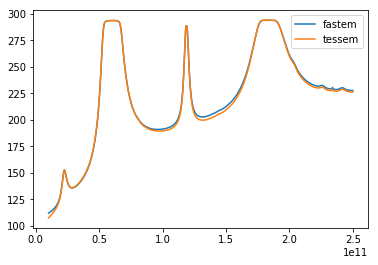

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ws.f_grid.value, y_fastem[0::2], label="fastem")
plt.plot(ws.f_grid.value, y_tessem[0::2], label="tessem")
plt.legend()

In [ ]:
plt.plot(ws.f_grid.value, y_fastem[0::2] - y_tessem[0::2])

In [ ]:
ws.Print("bla", 1)